# COGS 108 - EDA Checkpoint

# Names

- Mohamed Abdilahi
- Fajar Dirham
- Robbie Kovar 
- Julie Nagan
- Erik Cisneros

<a id='research_question'></a>
# Research Question

How do the amount of positive and negative tweets affect how well American movies do in the box office?



# Dataset(s)

### Dataset 1
- Dataset Name: Movie Report 
- Link to the dataset: https://www.the-numbers.com/movies/report/All/All/All/All/All/All/United-States/All/All/None/None/2021/2021/None/None/None/None/None/None?show-release-date=On&show-domestic-box-office=On&show-international-box-office=On&show-worldwide-box-office=On&view-order-by=domestic-box-office&view-order-direction=desc
- Number of observations: 100 

This dataset is the list of the top 100 American movies domestically, internationally, and worldwide. We will use this dataset to help us answer our research question on whether the amount of tweets is correlated to how well it does commercially.

### DataSet 2
- Dataset Name: Tweets Referencing the Top 100 American Movies 
- Link to the dataset: N/A, webscraped
- Number of observations: unknown at the moment

This dataset is scraped from Twitter, using a 3rd party scraping tool, snscrape. Using the titles found in the Movie Report dataset, we will fetch the number of tweets that reference these titles, and compare them across the board.

# Setup

In [1]:
# installation of webscraper
!pip install -q snscrape==0.3.4

In [2]:
# imported libraries
import os
from os.path import exists
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [3]:
#read datafile
data = pd.read_csv('./MovieReport.csv')
data.head()

,Unnamed: 0,Released,Title,Domestic\r\nBox Office,International\r\nBox Office,Worldwide\r\nBox Office
0,1,"Dec 17, 2021",Spider-Man: No Way Home,"$804,617,772","$1,083,808,579","$1,888,426,351"
1,2,"Sep 3, 2021",Shang-Chi and the Legend of the Ten R…,"$224,543,292","$207,700,000","$432,243,292"
2,3,"Oct 1, 2021",Venom: Let There be Carnage,"$213,550,366","$288,050,013","$501,600,379"
3,4,"Jul 9, 2021",Black Widow,"$183,651,655","$196,100,000","$379,751,655"
4,5,"Jun 25, 2021",F9: The Fast Saga,"$173,005,945","$548,072,000","$721,077,945"


# Data Cleaning

Describe your data cleaning steps here.

First we wrote some helper functions to assist us in the cleaning process.

In [4]:
# Helper Functions

# Function for getting the total number of tweets for a movie title
# from_date - datetime object to start search
# to_date - datetime object to stop search
# title - string title of movie
# returns int number of tweets for the movie 
def num_tweets(from_date, to_date, title):
    start = str(from_date).replace(' 00:00:00', '')
    end = str(to_date).replace(' 00:00:00', '')

    os.system(f"snscrape --since {start} twitter-search '{title} until:{end}' > result-tweets.txt")
    if os.stat("result-tweets.txt").st_size == 0:
       counter = 0
    else:
       df = pd.read_csv('result-tweets.txt', names=['link'])
       counter = df.size
    os.remove('result-tweets.txt')
    print('Number Of Tweets : '+ str(counter))
    return counter

# Function for getting the total number of tweets for a movie title
# from_date - datetime object to start search
# to_date - datetime object to stop search
# title - string title of movie
# N - int number of posts to fetch
# returns list of first N tweets about the movie title 
def get_N_posts(from_date, to_date, title, N):
  posts_list = []
  start = str(from_date).replace(' 00:00:00', '')
  end = str(to_date).replace(' 00:00:00', '')
  os.system("snscrape --format '{content!r}'"+ f" --max-results {N} --since {start} twitter-search '{title} until:{end}' > tweets.txt")
  if os.stat("tweets.txt").st_size == 0:
    os.remove('tweets.txt')
    return posts_list
  else:
    df = pd.read_csv('tweets.txt', names=['content'])
    for row in df['content'].iteritems():
      posts_list.append(row)
    os.remove('tweets.txt')
    return posts_list

# Function for converting date strings into pandas datatime objects
# start - string datetime to start search
# end - string datetime to stop search
# title - string title of movie
# returns int number of tweets for the movie
def standardize_date(str): 
  try:
    str = str.strip()

    str = str.replace('Jan ', "01/")
    str = str.replace('Feb ', "02/")
    str = str.replace('Mar ', "03/")
    str = str.replace('Apr ', "04/")
    str = str.replace('May ', "05/")
    str = str.replace('Jun ', "06/")
    str = str.replace('Jul ', "07/")
    str = str.replace('Aug ', "08/")
    str = str.replace('Sep ', "09/")
    str = str.replace('Oct ', "10/")
    str = str.replace('Nov ', "11/")
    str = str.replace('Dec ', "12/")

    str = str.replace(', ', "/")

    str = str.replace('/1/', "/01/")
    str = str.replace('/2/', "/02/")
    str = str.replace('/3/', "/03/")
    str = str.replace('/4/', "/04/")
    str = str.replace('/5/', "/05/")
    str = str.replace('/6/', "/06/")
    str = str.replace('/7/', "/07/")
    str = str.replace('/8/', "/08/")
    str = str.replace('/9/', "/09/")

    out = str
  except:
    out = "n/a" 

  return out

#### Dataset 1 Cleaning

In [5]:
 #simple renaming of columns so it can be easier to read
data = data.rename(columns={"Domestic\r\nBox Office":"Domestic Box Office", "International\r\nBox Office":"International Box Office", 
            "Worldwide\r\nBox Office":"Worldwide Box Office"})
data = data.drop(columns=['Unnamed: 0'])

# Transformation of release date string to 'datetime' objects
data['Released'] = data['Released'].apply(standardize_date)
data['Released'] = data['Released'].apply(pd.to_datetime)

# Sort Movies by release date
data = data.sort_values(by='Released')
data = data.reset_index(drop = True)

# Remove dollar signs and commas from the box office numbers and convert them to floats
data['Domestic Box Office'] = data['Domestic Box Office'].str.replace('$','')
data['Domestic Box Office'] = data['Domestic Box Office'].str.replace(',','').astype(float)
data['International Box Office'] = data['International Box Office'].str.replace('$','')
data['International Box Office'] = data['International Box Office'].str.replace(',','').astype(float)
data['Worldwide Box Office'] = data['Worldwide Box Office'].str.replace('$','')
data['Worldwide Box Office'] = data['Worldwide Box Office'].str.replace(',','').astype(float)

# Remove null
data.head()

,Released,Title,Domestic Box Office,International Box Office,Worldwide Box Office
0,2021-01-15,The Marksman,15566093.0,5631181.0,21197274.0
1,2021-01-26,Wrong Turn,1251184.0,2392576.0,3643760.0
2,2021-01-29,The Little Things,15342746.0,14392476.0,29735222.0
3,2021-01-29,Nomadland,2180000.0,36818715.0,38998715.0
4,2021-02-12,Judas and the Black Messiah,5478009.0,1580271.0,7058280.0


#### Dataset 2 Webscrape & Cleaning

In [17]:

# Parameters:
days_prerelease = 14      # days before release to start search
N = 100                   # number of posts to fetch; used to fetch first N posts
tweets_df = pd.DataFrame()

# for each title get a list of tuples.

for index, title in enumerate(data['Title']):
  date_released = data['Released'].iloc[index]
  date_of_interest = date_released - pd.Timedelta(days=days_prerelease)
  posts_list = get_N_posts(date_of_interest, date_released, title, N)
  tweets = pd.Series(data=posts_list)
  tweets_df[title] = tweets

tweets_df.head()


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  del sys.path[0]


,The Marksman,Wrong Turn,The Little Things,Nomadland,Judas and the Black Messiah,Land,Tom and Jerry,Raya and the Last Dragon,Chaos Walking,Boogie,...,Encanto,Licorice Pizza,Red Rocket,West Side Story,Nightmare Alley,Spider-Man: No Way Home,The King’s Man,The Matrix Resurrections,Sing 2,A Journal for Jordan
0,"(0, Review: Liam Neeson saves 'The Marksman' f...","(0, https://t.co/QtGLzfb8Ve\nMotorist under in...","(0, 'Is anyone else excited to watch The Littl...","(0, 'Melhor Edição #SpiritAwards\n\n• Andy Can...","(0, 'Judas and The Black Messiah... 👏🏾')","(0, @YHGreenParty Don't worry, when the #Great...","(0, And most important thing coming up in your...","(0, 'Anyways I’m gonna go see raya and the las...","(0, 'CHAOS WALKING MARATHON WOOO')","(0, '@ThatEricAlper How do you make a tissue d...",...,"(0, '@bellaballeste15 Mi prima: 4/10 pero q le...","(0, 'Time for some Pizza made of an unlikely m...","(0, 'LAT ‘Red Rocket’ review: A well-endowed p...",('De que no son ni las 6 y solo me salen funci...,('“No one is free from sin in this film. Moral...,"(0, 'SPIDER-MAN NO WAY HOME IN 3 HOURS')","(0, The King's Man tracking for $15-20mil open...",('Opinion seems super divided on the Matrix Re...,"(0, 'Tried out the Sing 2 Character Filter and...","(0, 'Interestg analysis but a softball assessm..."
1,"(1, 'THE MARKSMAN (2021) https://t.co/zCvKbgeS...","(1, SHE'S FINALLY HEADING OVER BUT SHE TOOK A ...","(1, 'It’s the little things in life.. like bei...","(1, '@sweet_oxo_dust 聞こえて良かった～😆🦉🎶\nハグハグありがと～！︎...","(1, Idk how I feel about Judas and the Black M...","(1, '@mof_land 上の子よりは見えてる感じ(まぶしいのはOK)\n\n赤目でもま...","(1, '@BoomerangToons can you please tell me wh...","(1, 'Contrary to what “Game of Thrones” might ...","(1, 'Chaos Walking is coming out tomorrow nigh...","(1, 'LET ALL THE CHILDREN BOOGIE 🕺🕺🕺 /ly')",...,"(1, '@rrrancia Estuve en NY en época de navida...","(1, @PElroy19 @socioaisghap @licoricepizza We ...","(1, '@letterboxd red rocket')",(Bientôt le thread de mes films préférés de l'...,('@PoggerzU https://t.co/JEjTTvZmND https://t....,"(1, 'Seated for Spider-Man: No Way Home. Excit...","(1, 'THE KING’S MAN TIME')",('THE MATRIX RESURRECTIONS Movie Review (2021)...,"(1, 'if i see one more “SCARLETT JOHANSSON?!?!...","(1, Michael B. Jordan wanted his A Journal for..."
2,"(2, '“ The marksman” I have to say one thing a...","(2, 'Wait! They are remaking #WrongTurn withou...","(2, So I have my own set of acronyms. Little ...","(2, 'Melhor Cinematografia #SpiritAwards\n\n• ...","(2, 'Whisper Numbers: Judas and the Black Mess...","(2, 'I never did figure out where the mystery ...","(2, '@alaskadog Tom and Jerry.')","(2, I'm so excited to watch Raya and the Last ...","(2, 'seated for chaos walking!! https://t.co/D...","(2, '🤣 it’s The Carolina crack boogie \n &amp...",...,"(2, Was at McDonald's tonight. Got a Happy Mea...","(2, 'Finishing tonight’s Thanksgiving meal wit...","(2, '‘Bout to see “Red Rocket”')","('queria tanto ver west side story no cinema, ...",('@jake_corenthose @gknout @RealGDT @SunsetGun...,"(2, 'what i would do to experience watching sp...","(2, Review: 'The King's Man' can't find the ri...",('@seanpalmer I wanted to discover that The Ma...,"(2, 'tomorrow im gonna dress up in full spider...","(2, 'Thinking of heading to the mall &amp; cat..."
3,"(3, '#TheMarksman Barely Rises Above Expectati...","(3, '@nancylasocki Applebees shoulda been the ...","(3, @maurachanz It's the Little Things. -Indie...","(3, '@kotaro_101 こしあん派の方が多いですよね☺')","(3, 'I have absolutely no desire to see ""Judas...","(3, '@Master_Ilustrin The bow of a ship headed...","(3, @Spiro99511426 @birenbomb Wrong wrong why ...","(3, 'gnt a música d raya and the last Dragon é...","(3, 'nick jonas in chaos walking???')","(3, '@Ikechi_OUFZ Pyra can boogie woogie on my...",...,"(3, @replaygucci @FilmUpdates @Variety I don't...","(3, 'about to watch licorice pizza :•) !!')","(3, '@Cade_Onder Red Rocket coming in hot')","('Seated for West Side Story', nan)",('462. 

In [18]:
tweets_df

,The Marksman,Wrong Turn,The Little Things,Nomadland,Judas and the Black Messiah,Land,Tom and Jerry,Raya and the Last Dragon,Chaos Walking,Boogie,...,Encanto,Licorice Pizza,Red Rocket,West Side Story,Nightmare Alley,Spider-Man: No Way Home,The King’s Man,The Matrix Resurrections,Sing 2,A Journal for Jordan
0,"(0, Review: Liam Neeson saves 'The Marksman' f...","(0, https://t.co/QtGLzfb8Ve\nMotorist under in...","(0, 'Is anyone else excited to watch The Littl...","(0, 'Melhor Edição #SpiritAwards\n\n• Andy Can...","(0, 'Judas and The Black Messiah... 👏🏾')","(0, @YHGreenParty Don't worry, when the #Great...","(0, And most important thing coming up in your...","(0, 'Anyways I’m gonna go see raya and the las...","(0, 'CHAOS WALKING MARATHON WOOO')","(0, '@ThatEricAlper How do you make a tissue d...",...,"(0, '@bellaballeste15 Mi prima: 4/10 pero q le...","(0, 'Time for some Pizza made of an unlikely m...","(0, 'LAT ‘Red Rocket’ review: A well-endowed p...",('De que no son ni las 6 y solo me salen funci...,('“No one is free from sin in this film. Moral...,"(0, 'SPIDER-MAN NO WAY HOME IN 3 HOURS')","(0, The King's Man tracking for $15-20mil open...",('Opinion seems super divided on the Matrix Re...,"(0, 'Tried out the Sing 2 Character Filter and...","(0, 'Interestg analysis but a softball assessm..."
1,"(1, 'THE MARKSMAN (2021) https://t.co/zCvKbgeS...","(1, SHE'S FINALLY HEADING OVER BUT SHE TOOK A ...","(1, 'It’s the little things in life.. like bei...","(1, '@sweet_oxo_dust 聞こえて良かった～😆🦉🎶\nハグハグありがと～！︎...","(1, Idk how I feel about Judas and the Black M...","(1, '@mof_land 上の子よりは見えてる感じ(まぶしいのはOK)\n\n赤目でもま...","(1, '@BoomerangToons can you please tell me wh...","(1, 'Contrary to what “Game of Thrones” might ...","(1, 'Chaos Walking is coming out tomorrow nigh...","(1, 'LET ALL THE CHILDREN BOOGIE 🕺🕺🕺 /ly')",...,"(1, '@rrrancia Estuve en NY en época de navida...","(1, @PElroy19 @socioaisghap @licoricepizza We ...","(1, '@letterboxd red rocket')",(Bientôt le thread de mes films préférés de l'...,('@PoggerzU https://t.co/JEjTTvZmND https://t....,"(1, 'Seated for Spider-Man: No Way Home. Excit...","(1, 'THE KING’S MAN TIME')",('THE MATRIX RESURRECTIONS Movie Review (2021)...,"(1, 'if i see one more “SCARLETT JOHANSSON?!?!...","(1, Michael B. Jordan wanted his A Journal for..."
2,"(2, '“ The marksman” I have to say one thing a...","(2, 'Wait! They are remaking #WrongTurn withou...","(2, So I have my own set of acronyms. Little ...","(2, 'Melhor Cinematografia #SpiritAwards\n\n• ...","(2, 'Whisper Numbers: Judas and the Black Mess...","(2, 'I never did figure out where the mystery ...","(2, '@alaskadog Tom and Jerry.')","(2, I'm so excited to watch Raya and the Last ...","(2, 'seated for chaos walking!! https://t.co/D...","(2, '🤣 it’s The Carolina crack boogie \n &amp...",...,"(2, Was at McDonald's tonight. Got a Happy Mea...","(2, 'Finishing tonight’s Thanksgiving meal wit...","(2, '‘Bout to see “Red Rocket”')","('queria tanto ver west side story no cinema, ...",('@jake_corenthose @gknout @RealGDT @SunsetGun...,"(2, 'what i would do to experience watching sp...","(2, Review: 'The King's Man' can't find the ri...",('@seanpalmer I wanted to discover that The Ma...,"(2, 'tomorrow im gonna dress up in full spider...","(2, 'Thinking of heading to the mall &amp; cat..."
3,"(3, '#TheMarksman Barely Rises Above Expectati...","(3, '@nancylasocki Applebees shoulda been the ...","(3, @maurachanz It's the Little Things. -Indie...","(3, '@kotaro_101 こしあん派の方が多いですよね☺')","(3, 'I have absolutely no desire to see ""Judas...","(3, '@Master_Ilustrin The bow of a ship headed...","(3, @Spiro99511426 @birenbomb Wrong wrong why ...","(3, 'gnt a música d raya and the last Dragon é...","(3, 'nick jonas in chaos walking???')","(3, '@Ikechi_OUFZ Pyra can boogie woogie on my...",...,"(3, @replaygucci @FilmUpdates @Variety I don't...","(3, 'about to watch licorice pizza :•) !!')","(3, '@Cade_Onder Red Rocket coming in hot')","('Seated for West Side Story', nan)",('462. 

# Data Analysis & Results (EDA)

#### Dataset 1

In [7]:
data

,Released,Title,Domestic Box Office,International Box Office,Worldwide Box Office
0,2021-01-15,The Marksman,15566093.0,5631181.0,21197274.0
1,2021-01-26,Wrong Turn,1251184.0,2392576.0,3643760.0
2,2021-01-29,The Little Things,15342746.0,14392476.0,29735222.0
3,2021-01-29,Nomadland,2180000.0,36818715.0,38998715.0
4,2021-02-12,Judas and the Black Messiah,5478009.0,1580271.0,7058280.0
...,...,...,...,...,...
95,2021-12-22,The King’s Man,37176373.0,83948927.0,121125300.0
96,2021-12-22,The Matrix Resurrections,37686805.0,118781012.0,156467817.0
97,2021-12-22,Sing 2,162790990.0,234806442.0,397597432.0
98,2021-12-25,American Underdog: The Kurt Warner Story,26514814.0,0.0,26514814.0


###### Size

For this dataset we have 100 entries

In [8]:
data.shape

(100, 5)

##### Missingness

Searching for any anomalous entries we found that 6 movies had an International Box Office of 0. We believe these movies didn't have an international box office because they only released domestically

In [9]:
domestic_only =  data[data['International Box Office'] == 0]
domestic_only

,Released,Title,Domestic Box Office,International Box Office,Worldwide Box Office
13,2021-04-02,The Girl Who Believes In Miracles,3163362.0,0.0,3163362.0
15,2021-04-23,Together Together,1436324.0,0.0,1436324.0
17,2021-04-30,Separation,4509143.0,0.0,4509143.0
32,2021-06-11,The House Next Door: Meet the Blacks 2,2893660.0,0.0,2893660.0
90,2021-12-01,Christmas with the Chosen: The Messen…,13388000.0,0.0,13388000.0
98,2021-12-25,American Underdog: The Kurt Warner Story,26514814.0,0.0,26514814.0


Since we are using box office as a measure of success for a movie, we will remove the aforementioned entries. Their lack of an international box office, makes it difficult to compare them with other movies at an international scope. Additionally it hinders their worldwide box office making them appear less successful than other movies.

In [10]:
data = data[data['International Box Office'] != 0]

Plotting a histogram for the release date of movies, we see that it is fairly uniformly distributed. There is a slight lack of movies during the first quarter the year 

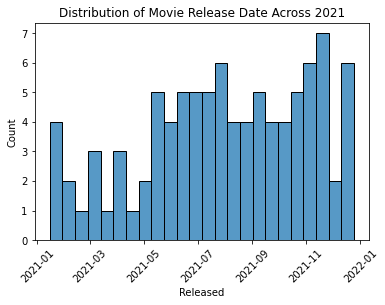

In [11]:
sns.histplot(data, x='Released', bins=24)
plt.title('Distribution of Movie Release Date Across 2021')
plt.xticks(rotation=45)
print()

Plotting for Box Office success, we see all three distributions are highly skewed right. We also spot a few outliers who earned huge box offices.

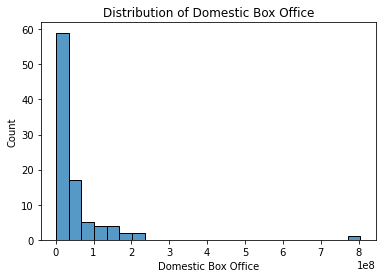

In [12]:
sns.histplot(data, x='Domestic Box Office', bins=24)
plt.title('Distribution of Domestic Box Office')
print()

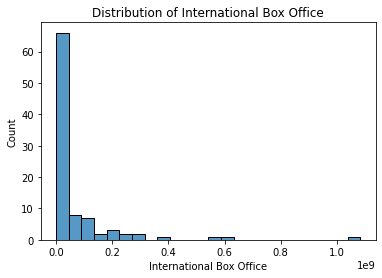

In [13]:
sns.histplot(data, x='International Box Office', bins=24)
plt.title('Distribution of International Box Office')
print()

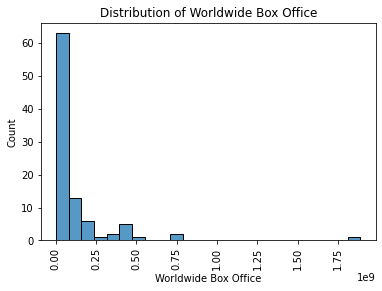

In [14]:
sns.histplot(data, x='Worldwide Box Office', bins=24)
plt.title('Distribution of Worldwide Box Office')
plt.xticks(rotation=90)
print()

###### Outliers

We see in both cases that the outlier ends up being "Spider-Man: No Way Home"

In [15]:
data[data['Domestic Box Office'] > (7*(10**8))]

,Released,Title,Domestic Box Office,International Box Office,Worldwide Box Office
94,2021-12-17,Spider-Man: No Way Home,804617772.0,1.083809e+09,1.888426e+09


In [16]:
data[data['Worldwide Box Office'] > (1*(10**9))]

,Released,Title,Domestic Box Office,International Box Office,Worldwide Box Office
94,2021-12-17,Spider-Man: No Way Home,804617772.0,1.083809e+09,1.888426e+09


#### Dataset 2

##### Sentiment Analysis
We will continue by doing sentiment analysis on the webscraped posts